In [328]:
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from functools import reduce
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier,RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, plot_roc_curve,plot_confusion_matrix, accuracy_score, precision_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder

# 1. Data exploration - load and merge feature and label data of the train set

In [329]:
#load feature_data
X = pd.read_csv("feature_data.csv")
#load_label_data
y = pd.read_csv("label_data.csv")
#change_column_names
X = X.rename(columns = {'Unnamed: 0':'id'})
y = y.rename(columns = {'Unnamed: 0':'id'})
#split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25,random_state = 42,shuffle = True)
#merge_data
new_df = pd.merge(X_train,y_train,on=['id'])
new_df.head()

,id,time_until_order,order_year,order_month,order_week,order_day_of_month,adults,children,babies,country,...,anon_feat_5,anon_feat_6,anon_feat_7,anon_feat_8,anon_feat_9,anon_feat_10,anon_feat_11,anon_feat_12,anon_feat_13,cancelation
0,32696,5.0,2017,January,week_5,30,2,2.0,0,MAR,...,6.0,0.0,1.0,0,1.0,0.502086,2.050217,True,0.0,False
1,27250,127.0,2017,August,week_33,18,2,0.0,0,PRT,...,4.0,0.0,NaN,4,1.0,0.444252,11.344172,False,NaN,False
2,84393,22.0,2016,February,week_9,22,2,0.0,0,PRT,...,3.0,0.0,0.0,1,NaN,0.551103,4.793369,False,NaN,False
3,109652,NaN,2017,April,week_15,9,2,0.0,0,GBR,...,0.0,0.0,0.0,1,0.0,0.319022,10.610277,False,NaN,False
4,116988,NaN,2017,July,week_30,25,3,0.0,0,FRA,...,3.0,0.0,1.0,0,0.0,0.492604,14.314214,True,0.0,False


In [330]:
#basic data info
print(new_df.shape)
new_df.info()

(67156, 35)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 67156 entries, 0 to 67155
Data columns (total 35 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   67156 non-null  int64  
 1   time_until_order     57706 non-null  float64
 2   order_year           67156 non-null  int64  
 3   order_month          64546 non-null  object 
 4   order_week           67156 non-null  object 
 5   order_day_of_month   67156 non-null  int64  
 6   adults               67156 non-null  int64  
 7   children             67152 non-null  float64
 8   babies               67156 non-null  int64  
 9   country              63915 non-null  object 
 10  order_type           67156 non-null  object 
 11  acquisition_channel  67156 non-null  object 
 12  prev_canceled        67156 non-null  int64  
 13  prev_not_canceled    67156 non-null  int64  
 14  changes              64561 non-null  float64
 15  deposit_type         603

In [331]:
#empty_val_stats - 
def na_stats (df):
    df.isnull().sum()
    total = df.isnull().sum()
    percent_missing = df.isnull().sum() * 100 / len(df)
    missing_value_df = pd.DataFrame({'total': total,
                                     'percent_missing': percent_missing})
    missing_value_df.sort_values('percent_missing', inplace=True, ascending=False)
    return missing_value_df
print(na_stats (new_df))
# note: we can restore NA values of 'month' from corresponding 'week', which indicates they have strong
# corelation and we can maybe exclude one of them

                     total  percent_missing
company              63360        94.347489
anon_feat_13         62850        93.588064
time_until_order      9450        14.071714
agent                 9163        13.644350
customer_type         7384        10.995295
deposit_type          6783        10.100363
anon_feat_11          3696         5.503604
country               3241         4.826077
anon_feat_6           3157         4.700995
anon_feat_7           3149         4.689082
anon_feat_5           3023         4.501459
anon_feat_9           2789         4.153017
order_month           2610         3.886473
changes               2595         3.864137
anon_feat_0           2526         3.761391
adr                   2269         3.378700
anon_feat_10          2069         3.080886
children                 4         0.005956
anon_feat_8              0         0.000000
anon_feat_3              0         0.000000
anon_feat_12             0         0.000000
anon_feat_4              0      

In [332]:
#load test to see if NA stats are same as 
T = pd.read_csv("feature_data_test.csv")
#change_column_names
T = T.rename(columns = {'Unnamed: 0':'id'})
print(na_stats (T))

                     total  percent_missing
company              28113        94.187215
anon_feat_13         27905        93.490351
time_until_order      4253        14.248861
agent                 4144        13.883677
customer_type         3287        11.012463
deposit_type          3051        10.221790
anon_feat_11          1689         5.658671
anon_feat_6           1410         4.723935
country               1407         4.713884
anon_feat_7           1368         4.583222
anon_feat_5           1352         4.529617
anon_feat_9           1254         4.201287
order_month           1167         3.909810
changes               1104         3.698740
anon_feat_0           1091         3.655186
adr                   1027         3.440767
anon_feat_10           896         3.001876
anon_feat_8              0         0.000000
anon_feat_2              0         0.000000
anon_feat_4              0         0.000000
anon_feat_12             0         0.000000
anon_feat_3              0      

# Numerical and categorial features

In [333]:
#Split numerical and categorial data
def num_cat_split(X):
    X_num = X.select_dtypes(include=[np.number])
    X_categ = X.select_dtypes(exclude=[np.number])
    return X_num, X_categ

X_num, X_categ = num_cat_split(X_train)

In [334]:
# find the threshold for number of countries before handeling the data
def get_country_index (X):
    threshold = [0.90,0.95,0.99]
    print(threshold)
    print(X['country'].value_counts(normalize=True).cumsum().searchsorted(threshold))
    country_indx = X['country'].value_counts(normalize=True).cumsum().searchsorted(threshold[0])
    print (country_indx)

# seems like 90% of the data is represented by 13 countries in the training 
# and we have 155 countries that can be dealt otherwise

def change_country_outliers (X):
    countries_in_threshold = X['country'].value_counts(normalize=True)[13:].index.tolist()
    X['country'].replace(to_replace=countries_in_threshold, value="OTHER", inplace=True)
    return X
def fillna_country(X):
    X.country.fillna("OTHER",inplace=True)
    return X
def country_to_num(X):
    le = LabelEncoder()
    le.fit(X.country.unique())
    X['country'] = le.transform(X['country'])
    return (X['country'])




## Handeling catecorial fetures

In [335]:
# we can easily deal with 'order_month','order_week' by converting them to their corresponding numbers,
# and 'anon_feat_12' to binary values. All the other categories will get mapped numbers for each value 
c = X_categ.copy()
months = {'January':1,'February':2,'March':3,'April': 4,'May': 5,'June': 6,'July': 7,'August': 8,'September': 9,'October': 10,'November': 11,'December': 12}
# we will probable want to use get_dummies for those, for now i'm changing it so we can look at correlations with lables
order_t = {'Offline TA/TO':1,'Online TA':2,'Direct':3,'Corporate':4,'Groups':5,'Aviation':6,'Complementary':7,'Undefined':8}
acq_c = {'TA/TO':1,'GDS':2,'Direct':3,'Corporate':4,'Undefined':5}
dep_t = {'No Deposit':1,'Non Refund':2,'Refundable':3}
cus_t = {'Transient-Party':1,'Transient':2,'Contract':3,'Group':4}
categories = ['order_month','order_type','acquisition_channel','deposit_type','customer_type']
categ_dicts = [months, order_t, acq_c, dep_t, cus_t]




In [336]:
def categ_to_num (X, categories, val_dicts):
    for cat, dic in zip(categories ,val_dicts):
        X[cat].replace(dic, inplace=True)

categ_to_num (c, categories, categ_dicts)

# week, and use values to fill NA for months
def replace_week(X):
    X['order_week'] = X['order_week'].str.slice(start=5).apply(pd.to_numeric)
    X['order_month'].fillna((X['order_week']/4.3).apply(np.ceil), inplace = True)  #calc month for NA values from week
replace_week(c)
    
def replace_boolean(X, category):
    X[category] = X[category].astype(int)
replace_boolean(c, 'anon_feat_12')
    
def handle_country (c):
    get_country_index(c)
    c = change_country_outliers(c)
    c = fillna_country(c)
    c = country_to_num(c)
    return c
handle_country(c)

c.info()
c.head()
#joining data to numerical dataframe
#for now, I didn't handle Country so I didn't add it

X_num = X_num.join(c)

[0.9, 0.95, 0.99]
[13 21 55]
13
<class 'pandas.core.frame.DataFrame'>
Int64Index: 67156 entries, 72578 to 15795
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   order_month          67156 non-null  float64
 1   order_week           67156 non-null  int64  
 2   country              67156 non-null  int64  
 3   order_type           67156 non-null  int64  
 4   acquisition_channel  67156 non-null  int64  
 5   deposit_type         60373 non-null  float64
 6   customer_type        59772 non-null  float64
 7   anon_feat_12         67156 non-null  int64  
dtypes: float64(3), int64(5)
memory usage: 4.6 MB


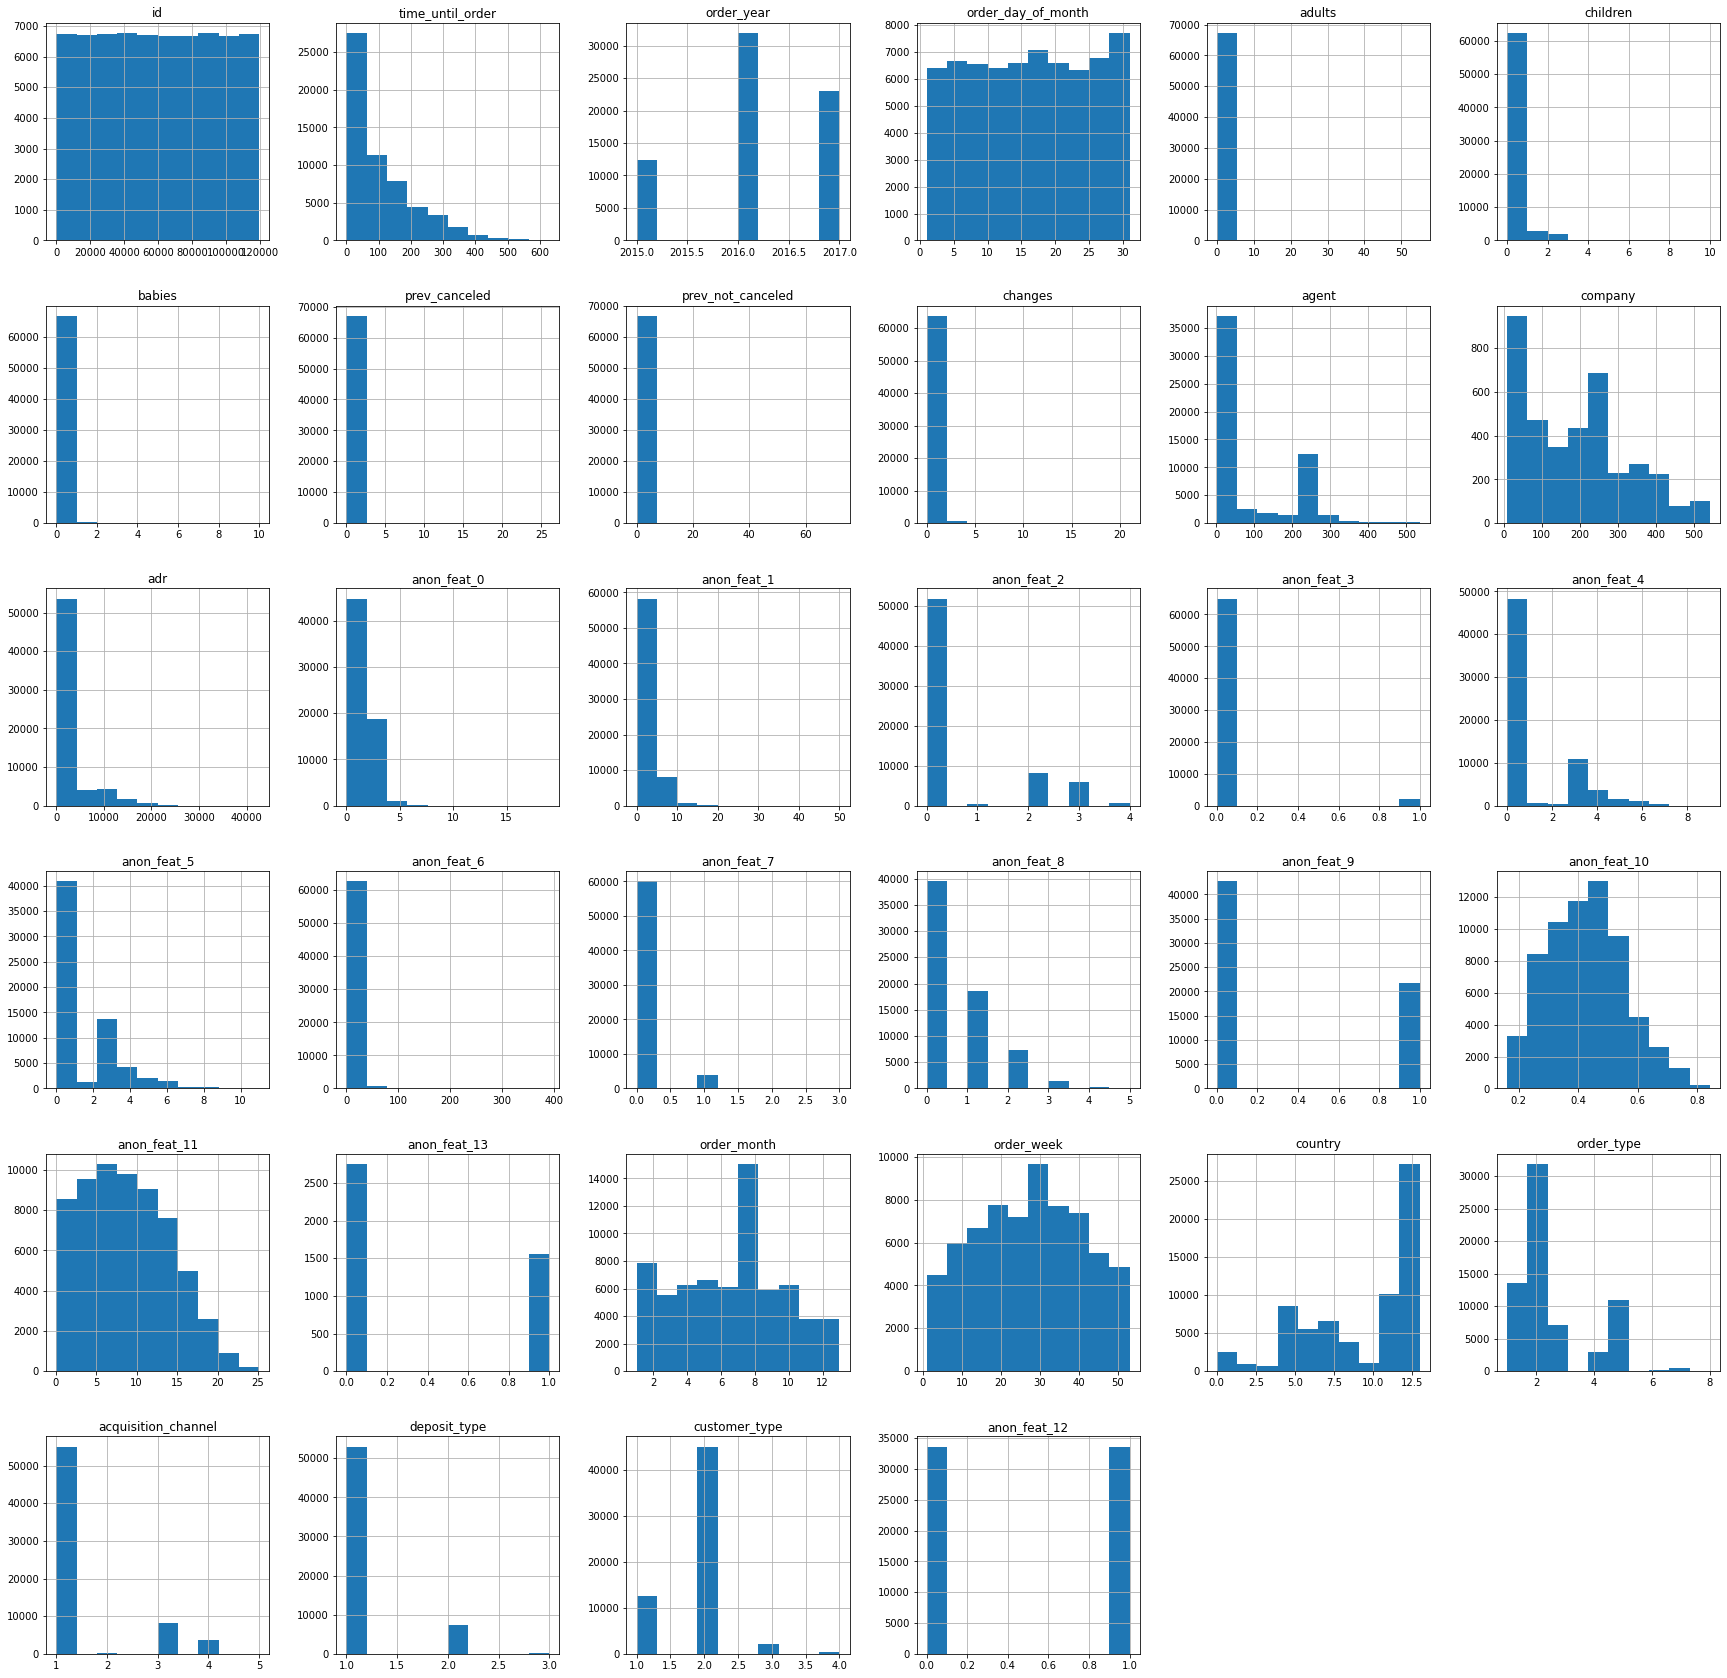

In [337]:
#Feature_histogram
X_num.hist(figsize=(30,30))
plt.show()

# some initial conclusions:
# outlayers:
# 1. we will probably want to handle ['adults','children','babies','adr','annot_feat_0-1,6']
# 2. maybe we won't touch these features? because we can get the intuition that these outlayers will be important?
# ['prev_not_canceled',prev_canceled','changes','','']
# normalization = ['']?
# log = ['time_until_order']?

<AxesSubplot:>

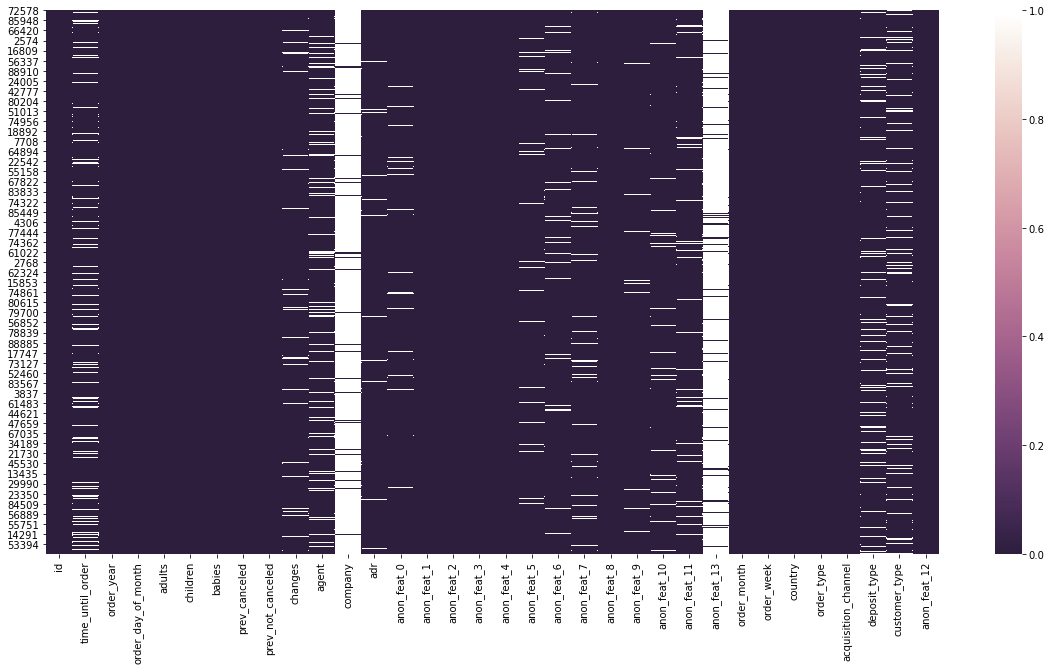

In [338]:
#plot null values per row
%matplotlib inline
plt.figure(figsize=(20, 10))
cmap = sns.cubehelix_palette(light=1, as_cmap=True, reverse=True)
sns.heatmap(X_num.isnull(), cmap=cmap)
#columns we might want to drop due to multyple NA ['company','anon_feat_13']


# Correlations w/o lables

In [339]:
# we need to decide if to fillna before we do correlation heatmap or after
# fix categorial vs numerical
# fillna according to outliers in numerical - mean/median
# outliers visulaization - boxplot
# correlation heatmap
# pca

#features thoughts:
#agent - maybe its also categorial?

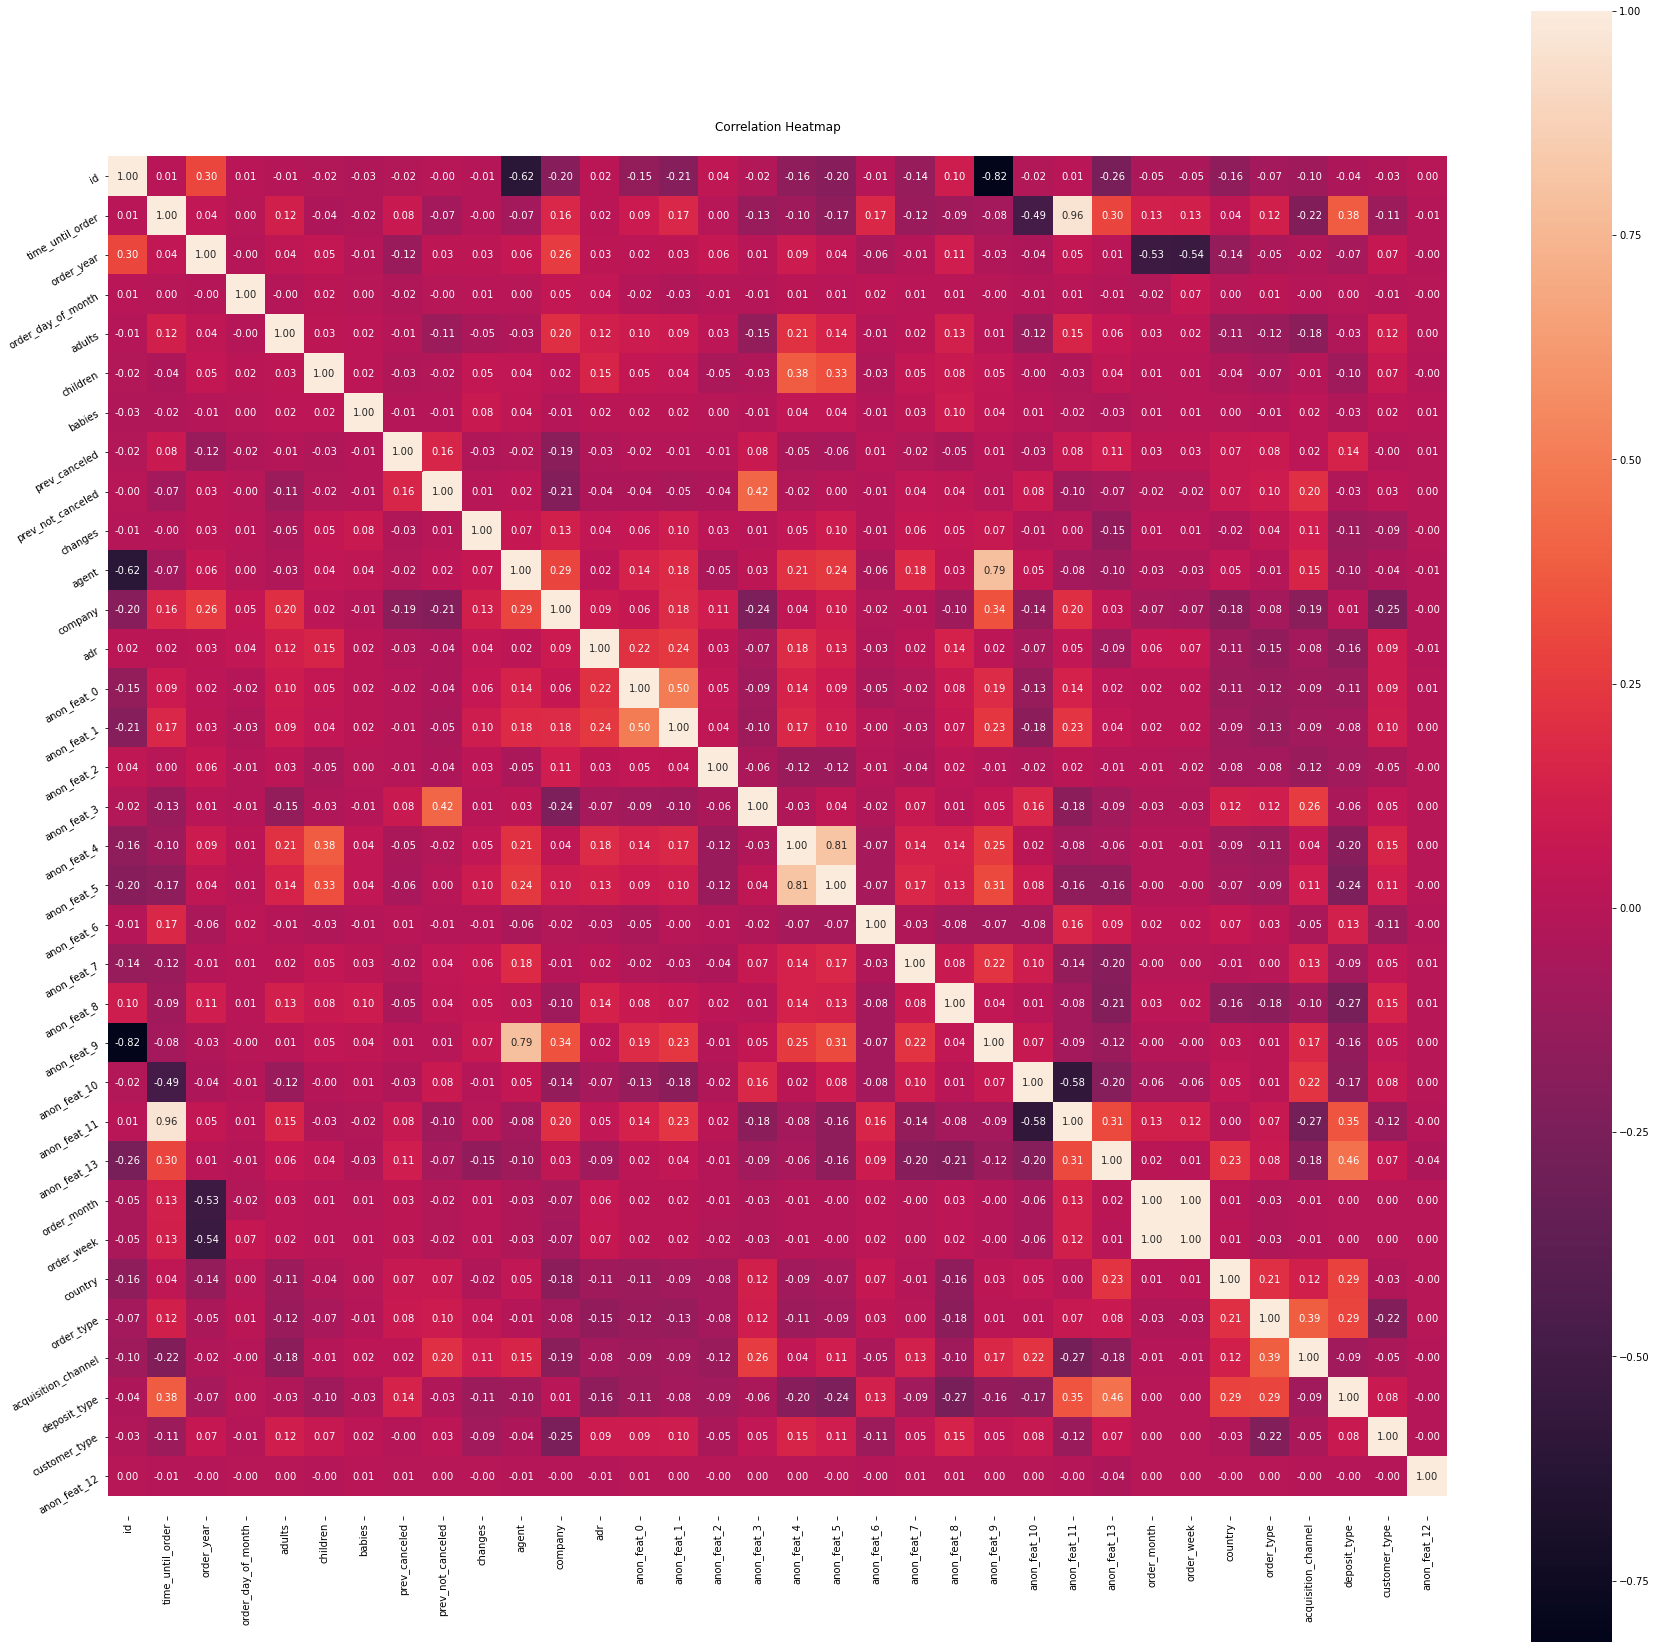

In [340]:
correlation = X_num.corr()
plt.figure(figsize=(30,30))
plt.title('Correlation Heatmap')
ax = sns.heatmap(correlation, square=True, annot=True, fmt='.2f', linecolor='white')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)                 
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_yticklabels(ax.get_yticklabels(), rotation=30)           
plt.show()

# We see high correlation between time_until_order to anon_feat_11
# We see high correlation between agent and anon_feat_9
# We see high correlation between anon_feat_4 and anon_feat_5
# We see low correlation between anon_feat_10 and anon_feat_11

# Creating new features

In [341]:
def new_feature (X):
    X['cancelation_percentage'] = X['prev_canceled']/(X['prev_canceled']+X['prev_not_canceled'])
    X['cancelation_percentage'].fillna(0, inplace = True)
    return(X)
new_feature(X_num)

,id,time_until_order,order_year,order_day_of_month,adults,children,babies,prev_canceled,prev_not_canceled,changes,...,anon_feat_13,order_month,order_week,country,order_type,acquisition_channel,deposit_type,customer_type,anon_feat_12,cancelation_percentage
72578,32696,5.0,2017,30,2,2.0,0,0,0,0.0,...,0.0,1.0,5,11,3,3,1.0,NaN,1,0.0
66308,27250,127.0,2017,18,2,0.0,0,0,1,4.0,...,NaN,8.0,33,12,3,1,1.0,NaN,0,0.0
25709,84393,22.0,2016,22,2,0.0,0,0,0,0.0,...,NaN,2.0,9,12,2,1,1.0,2.0,0,0.0
40632,109652,NaN,2017,9,2,0.0,0,0,0,0.0,...,NaN,4.0,15,7,2,1,1.0,2.0,0,0.0
38959,116988,NaN,2017,25,3,0.0,0,0,0,0.0,...,0.0,7.0,30,6,2,1,NaN,2.0,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6265,118744,96.0,2017,21,2,0.0,0,0,0,0.0,...,NaN,8.0,34,7,1,1,1.0,2.0,0,0.0
54886,32205,NaN,2017,16,1,0.0,0,0,0,2.0,...,NaN,1.0,3,12,5,3,1.0,1.0,0,0.0
76820,87011,36.0,2016,11,2,0.0,0,0,0,0.0,...,NaN,4.0,16,6,2,1,1.0,2.0,0,0.0
860,91124,NaN,2016,13,2,0.0,0,0,0,0.0,...,NaN,6.0,25,4,2,1,1.0,2.0,1,0.0


# Correlations with lables

In [342]:
X_num.corrwith(y['cancelation']).sort_values(ascending=False)

anon_feat_13              1.000000
deposit_type              0.465093
anon_feat_11              0.312541
time_until_order          0.292467
cancelation_percentage    0.290626
country                   0.254068
order_type                0.111057
prev_canceled             0.108540
customer_type             0.084831
anon_feat_6               0.058195
adults                    0.056654
anon_feat_1               0.027683
order_month               0.014931
order_year                0.014521
order_week                0.012003
children                  0.005075
anon_feat_0              -0.000334
anon_feat_12             -0.007302
order_day_of_month       -0.009336
anon_feat_2              -0.016290
company                  -0.019220
babies                   -0.032507
prev_not_canceled        -0.060029
anon_feat_4              -0.061918
adr                      -0.070128
agent                    -0.081958
anon_feat_3              -0.088319
anon_feat_9              -0.136613
changes             

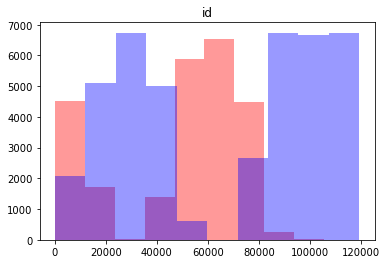

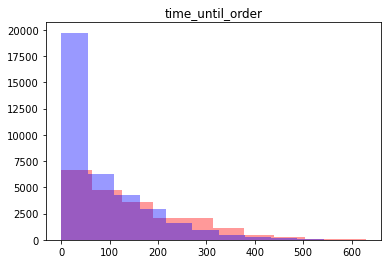

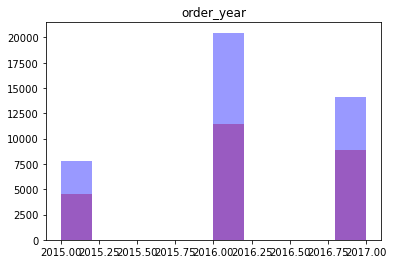

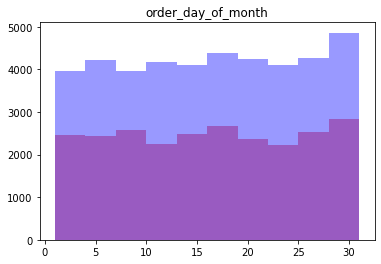

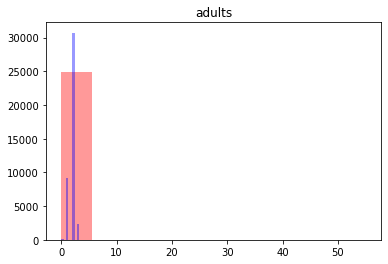

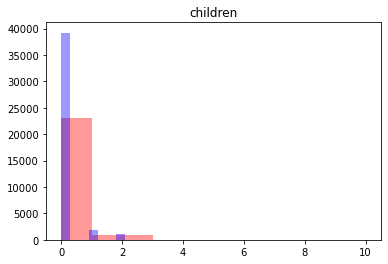

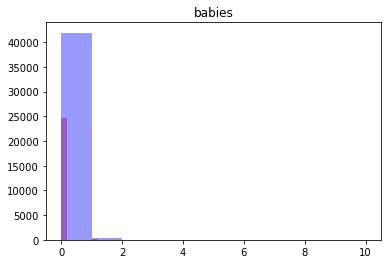

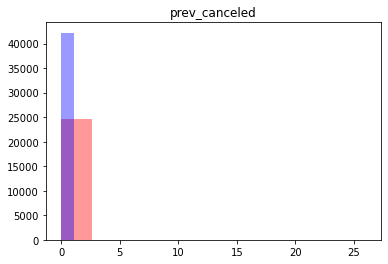

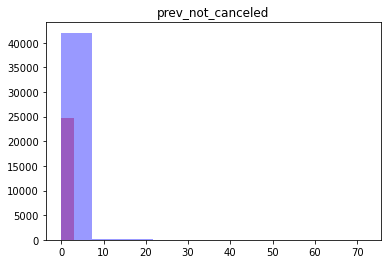

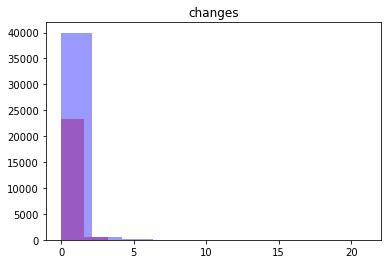

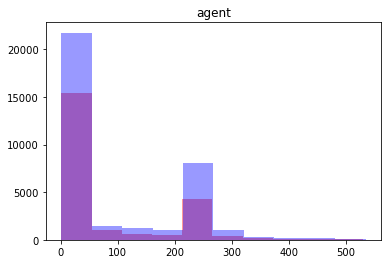

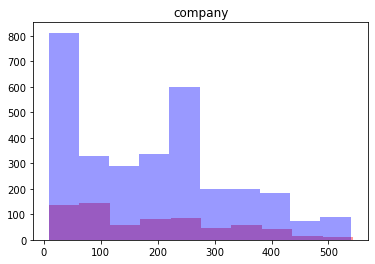

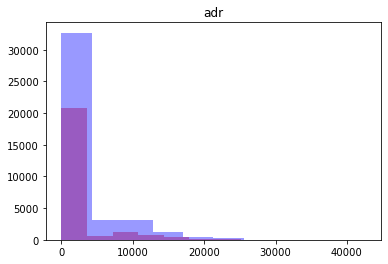

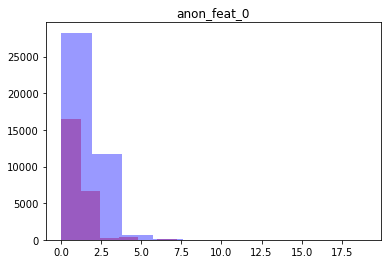

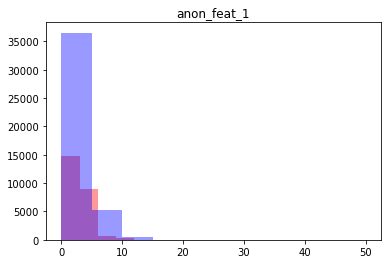

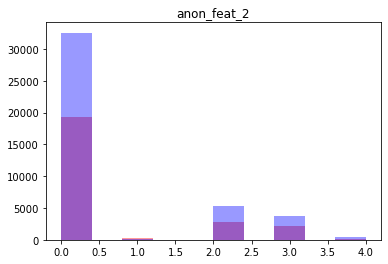

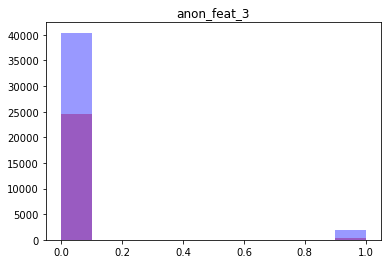

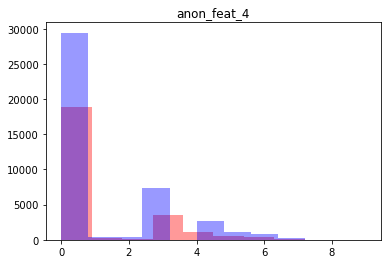

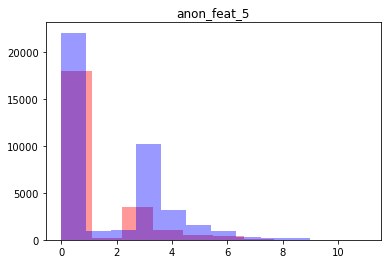

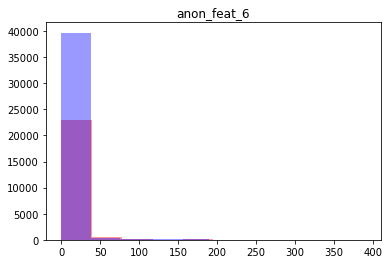

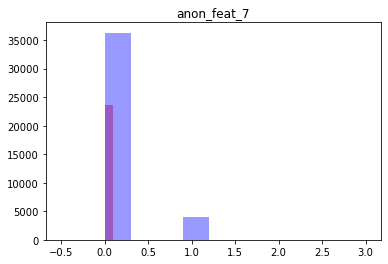

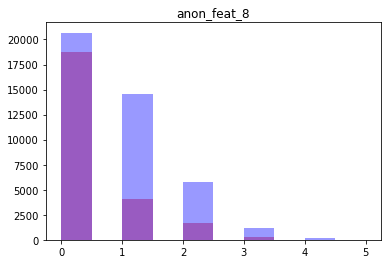

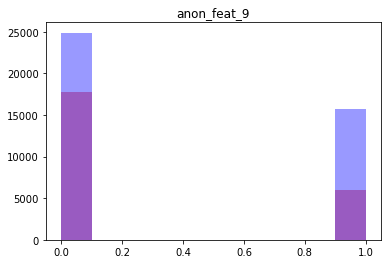

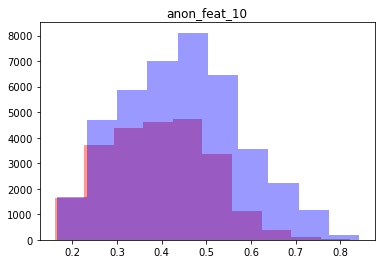

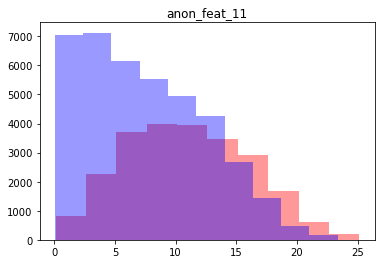

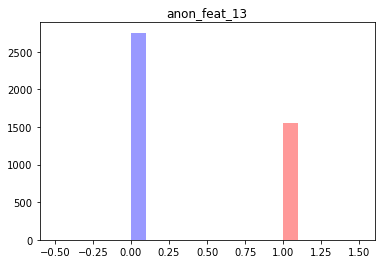

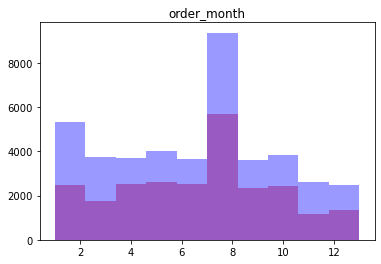

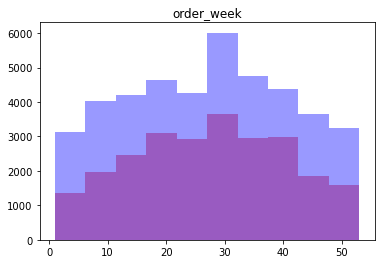

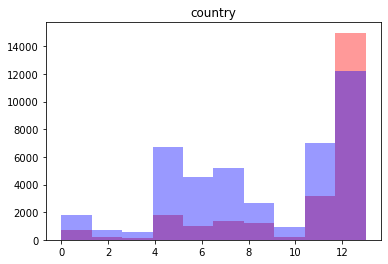

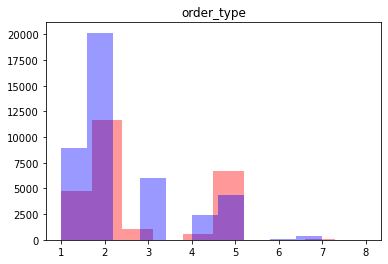

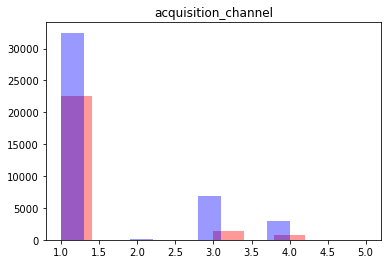

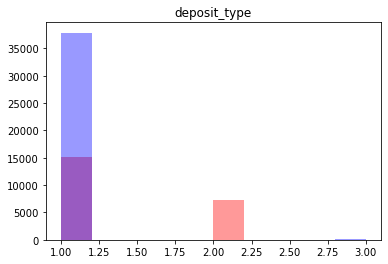

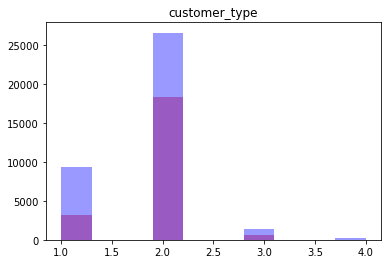

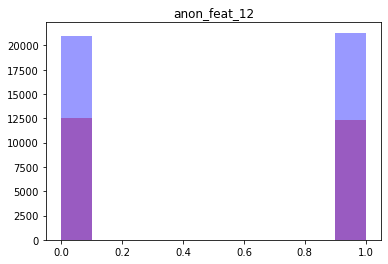

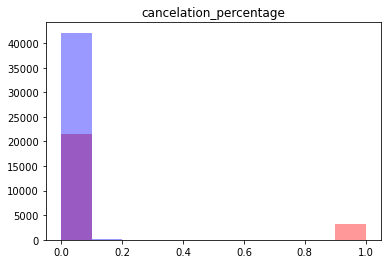

In [343]:
#Distribution of pos and neg labels by feautre, this is done again with normalization next
for col in X_num.columns:
    pos = X_num[col][y['cancelation'].astype(bool)]
    neg = X_num[col][~y['cancelation'].astype(bool)]
    plt.hist(pos,color ='r', alpha=0.4, label='Positive')
    plt.hist(neg, color='b', alpha=0.4, label ='Negative')
    plt.title(col)
    plt.show()

In [344]:
# features that seem with high corellation ['time_until_order'?,'order_year','order_day_of_month','agent','annot_feat_2,6,12','','','','','','',]
# features that apears strong ['annot_feat_9,10','deposit_type','agent']

id


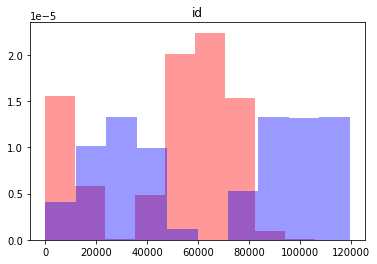

time_until_order


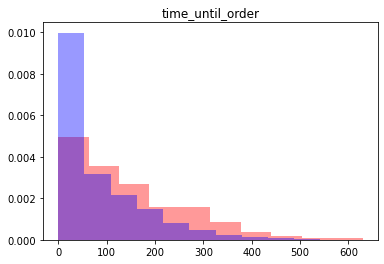

order_year


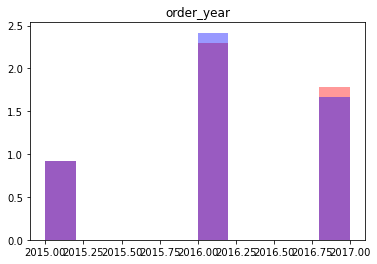

order_day_of_month


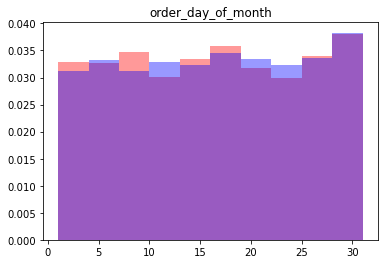

adults


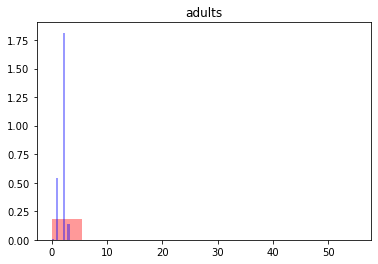

children


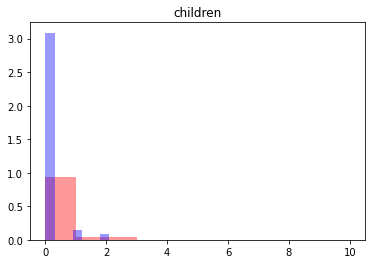

babies


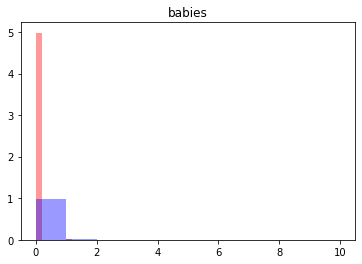

prev_canceled


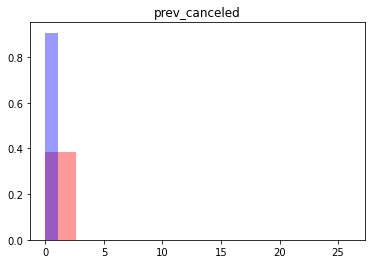

prev_not_canceled


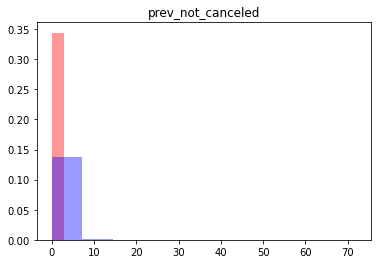

changes


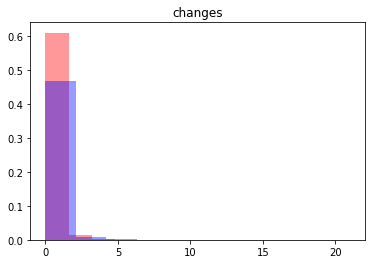

agent


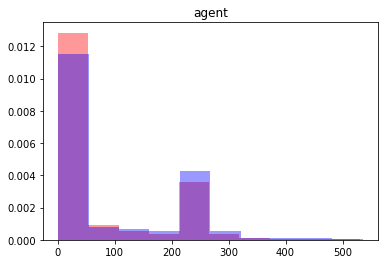

company


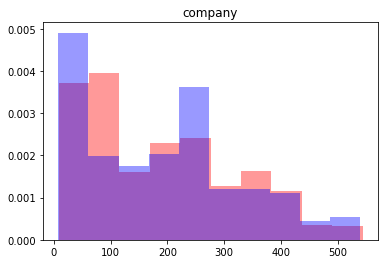

adr


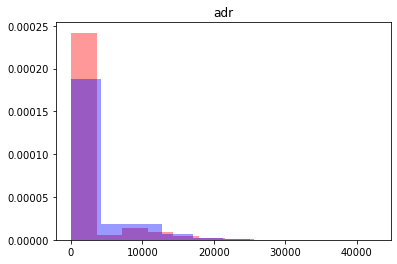

anon_feat_0


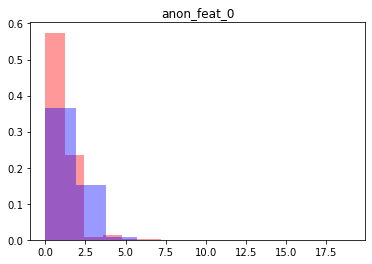

anon_feat_1


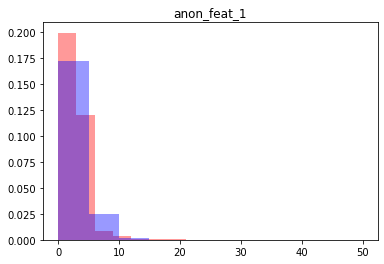

anon_feat_2


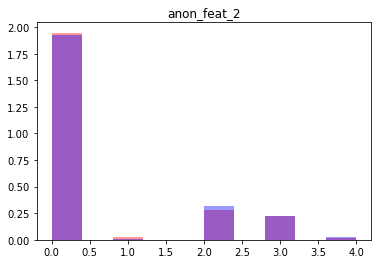

anon_feat_3


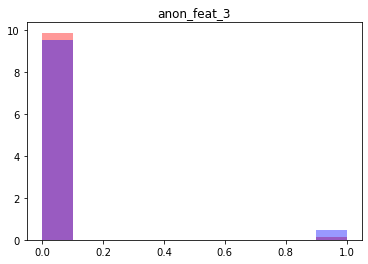

anon_feat_4


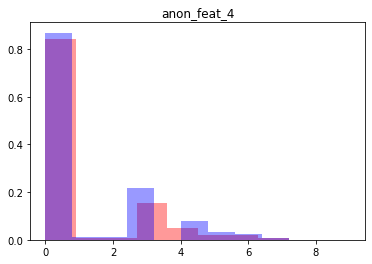

anon_feat_5


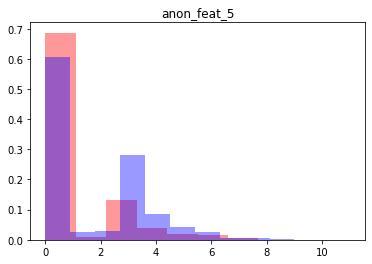

anon_feat_6


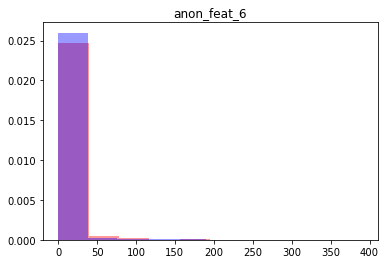

anon_feat_7


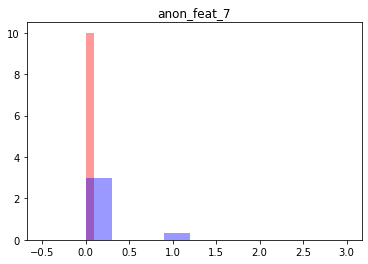

anon_feat_8


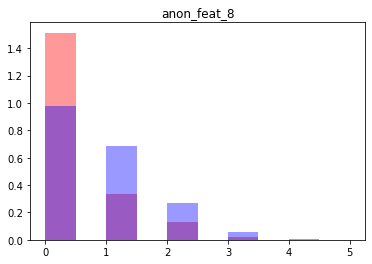

anon_feat_9


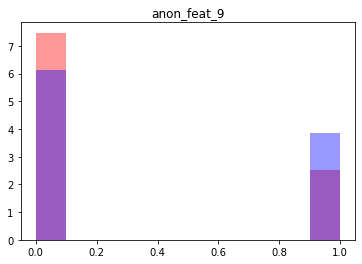

anon_feat_10


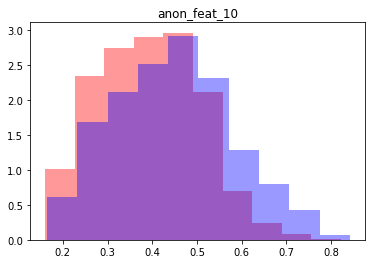

anon_feat_11


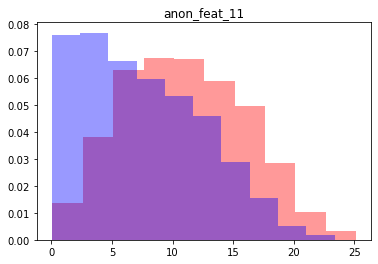

anon_feat_13


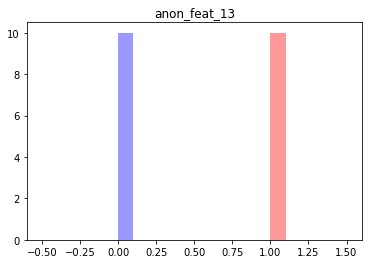

order_month


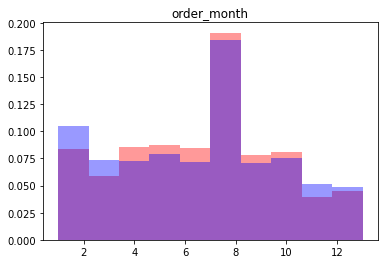

order_week


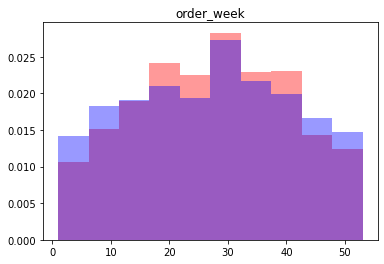

country


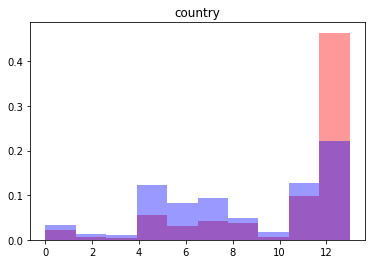

order_type


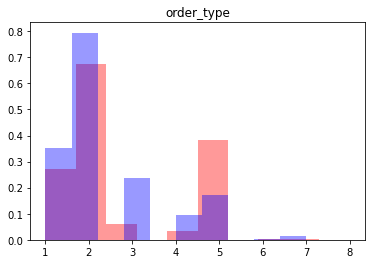

acquisition_channel


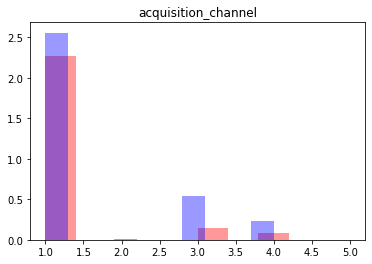

deposit_type


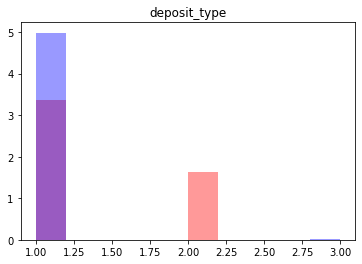

customer_type


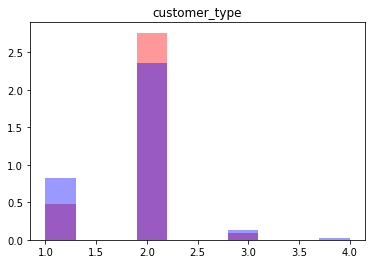

anon_feat_12


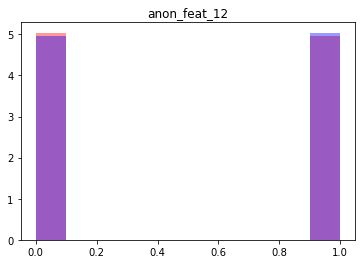

cancelation_percentage


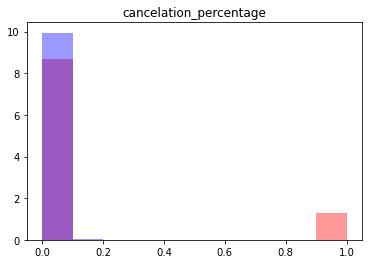

In [345]:
#with normalization
for col in X_num.columns:
    print(col)
    not_na = ~X_num[col].isna()
    pos = X_num[col][y['cancelation'].astype(bool)][not_na]
    neg = X_num[col][~y['cancelation'].astype(bool)][not_na]
    plt.hist(pos,color ='r', alpha=0.4, label='Positive', density = True)
    plt.hist(neg, color='b', alpha=0.4, label ='Negative', density = True)
    plt.title(col)
    plt.show()

# Handling outlayers

3 ,  adults :  0.0005360652808386444
3 ,  babies :  0.007743165167669307
3 ,  children :  0.031508725951515874
4 ,  adults :  8.934421347310739e-05
4 ,  babies :  0.007743165167669307
4 ,  children :  0.031508725951515874
4.5 ,  adults :  8.934421347310739e-05
4.5 ,  babies :  0.007743165167669307
4.5 ,  children :  0.031508725951515874
5 ,  adults :  8.934421347310739e-05
5 ,  babies :  0.007743165167669307
5 ,  children :  0.0006403001965572696


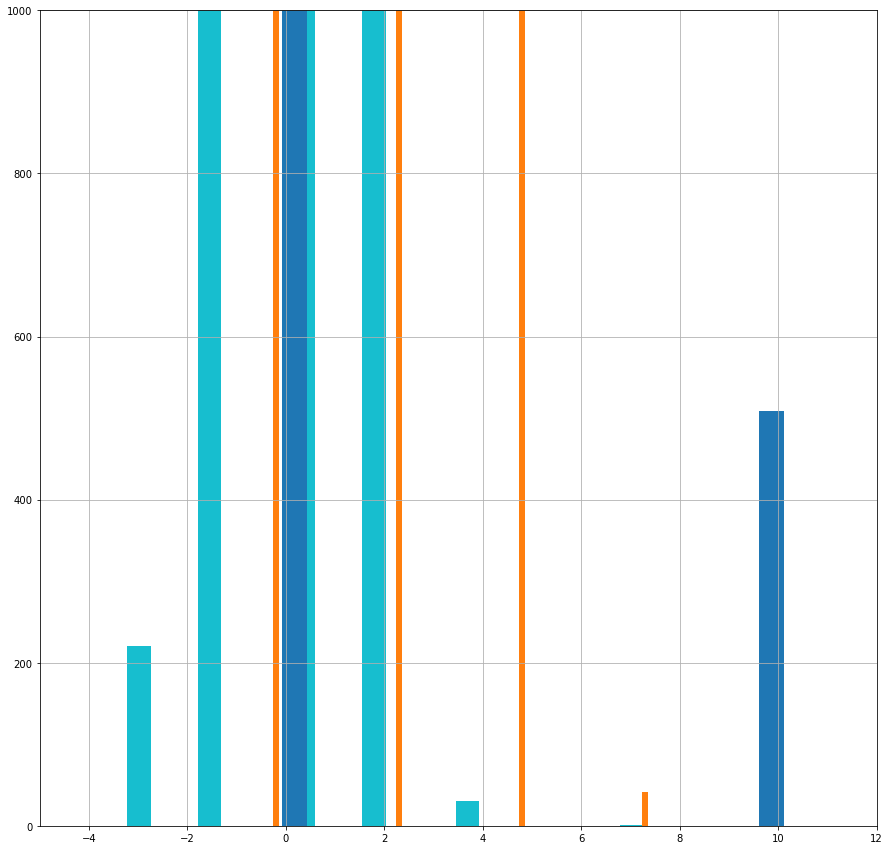

In [346]:
# 1. we will probably want to handle ['adults','children','babies','adr','annot_feat_0-1,6']
# 2. maybe we won't touch these features? because we can get the intuition that these outliers  will be important?
# ['prev_not_canceled',prev_canceled','changes','','']

#first, we'll look at the z-scores table and different thresholds for cutting the outliers
out = ['adults','babies','children']
thresh = [3, 4, 4.5, 5]

for t in thresh:
    for col in out:
        z_scores = ((X_num[col]-X_num[col].mean())/X_num[col].std(ddof=0))
        z_scores.hist(bins=200, figsize=(15,15))
        plt.xlim(-5, 12)
        plt.ylim(0, 1000)
        print(t,", ",col, ": ",(z_scores>=t).mean() )


# lets clear those 3 outliers

In [347]:
#after choosing the propper threshold for each feature, we're using it to cut the outliers 
z_thresh = [3,3,5]
print("x shpae:", X_num.shape)
print("y shpae:", y_train.shape)
for col,z in zip(out,z_thresh):
    z_scores = ((X_num[col]-X_num[col].mean())/X_num[col].std(ddof=0))
    print(col, ": ",(z_scores>=z).mean() )
    print("x shpae:", X_num.shape)
    print("y shpae:", y_train.shape)
    X_num, y_train = X_num[z_scores<z], y_train[z_scores<z]
    print("after",str(col), "removal x shpae:", X_num.shape)
    print("after removal y shpae:", y_train.shape)

x shpae: (67156, 35)
y shpae: (67156, 2)
adults :  0.0005360652808386444
x shpae: (67156, 35)
y shpae: (67156, 2)
after adults removal x shpae: (67120, 35)
after removal y shpae: (67120, 2)
babies :  0.0077473182359952325
x shpae: (67120, 35)
y shpae: (67120, 2)
after babies removal x shpae: (66600, 35)
after removal y shpae: (66600, 2)
children :  0.0006456456456456456
x shpae: (66600, 35)
y shpae: (66600, 2)
after children removal x shpae: (66553, 35)
after removal y shpae: (66553, 2)


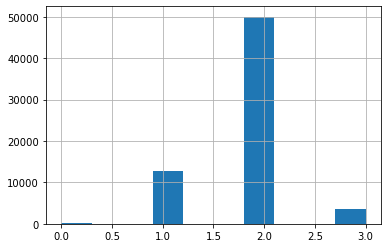

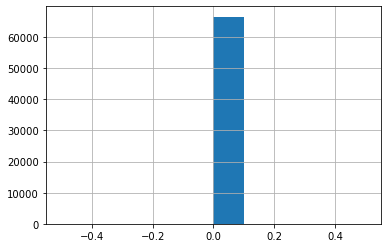

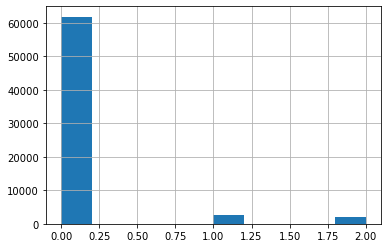

In [348]:
# new feature histograms after cutting the data
X_num['adults'].hist()
plt.show()
X_num['babies'].hist()
plt.show()
X_num['children'].hist()
plt.show()

# 2 - preprocessing

In [349]:
#Drop non interseting features
def drop_val(X):
    X.drop(['company','anon_feat_13','babies'],axis = 1,inplace = True)

In [350]:
#fill by median
med_feat = ['adr','agent','changes','anon_feat_6','anon_feat_0']

def fill_median(X): 
    for c in med_feat:
        imp = SimpleImputer(strategy='median')
        imp.fit(X[[c]])
        X[c] = imp.transform(X[[c]])
    return X

In [351]:
#fill by mean
mea_feat = ['time_until_order','anon_feat_7','anon_feat_5','anon_feat_10','anon_feat_11']
def fill_mean(X):
    for c in mea_feat:
        imp = SimpleImputer(strategy='mean')
        imp.fit(X[[c]])
        X[c] = imp.transform(X[[c]])
    return X


In [352]:
#fill by most_frequent the missing categorial data
by_freq = ['deposit_type','customer_type','anon_feat_9']
def fill_freq(X):
    for c in by_freq:
        missing = X[c].isnull()
        s = X[c].value_counts(normalize=True)
        X.loc[missing,c] = np.random.choice(s.index, size=len(X[missing]),p=s.values)
    return X


In [353]:
#Fill missing values in train - 
def preprocessing (X):
    drop_val(X)
    fill_median(X)
    fill_mean(X)
    fill_freq(X)
    return(X)

In [354]:
#Preprocessing Train
X_train_copy = X_num.copy()
preprocessing(X_train_copy)
X_train_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66553 entries, 72578 to 15795
Data columns (total 32 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      66553 non-null  int64  
 1   time_until_order        66553 non-null  float64
 2   order_year              66553 non-null  int64  
 3   order_day_of_month      66553 non-null  int64  
 4   adults                  66553 non-null  int64  
 5   children                66553 non-null  float64
 6   prev_canceled           66553 non-null  int64  
 7   prev_not_canceled       66553 non-null  int64  
 8   changes                 66553 non-null  float64
 9   agent                   66553 non-null  float64
 10  adr                     66553 non-null  float64
 11  anon_feat_0             66553 non-null  float64
 12  anon_feat_1             66553 non-null  int64  
 13  anon_feat_2             66553 non-null  int64  
 14  anon_feat_3             66553 non-

# Val set pre-processing


In [365]:
# Split numerical and categorial data of the test set
X_num_val, X_categ_val = num_cat_split(X_val)
#create copy for handeling categroial data
c1 = X_categ_val.copy()
#handeling categroial data
categ_to_num (c1, categories, categ_dicts)
replace_week(c1)
replace_boolean(c1, 'anon_feat_12')
handle_country(c1)
#join categorial transformed data
X_num_val = X_num_val.join(c1)
#add cancelation_percentage
new_feature(X_num_val)
X_num_val.info()

[0.9, 0.95, 0.99]
[14 22 53]
14
<class 'pandas.core.frame.DataFrame'>
Int64Index: 22386 entries, 23476 to 19170
Data columns (total 35 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      22386 non-null  int64  
 1   time_until_order        19155 non-null  float64
 2   order_year              22386 non-null  int64  
 3   order_day_of_month      22386 non-null  int64  
 4   adults                  22386 non-null  int64  
 5   children                22386 non-null  float64
 6   babies                  22386 non-null  int64  
 7   prev_canceled           22386 non-null  int64  
 8   prev_not_canceled       22386 non-null  int64  
 9   changes                 21504 non-null  float64
 10  agent                   19353 non-null  float64
 11  company                 1266 non-null   float64
 12  adr                     21672 non-null  float64
 13  anon_feat_0             21531 non-null  float64
 14  an

In [366]:
#Preprocessing Val -
X_num_val_copy = X_num_val.copy()
preprocessing(X_num_val_copy)
X_num_val_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22386 entries, 23476 to 19170
Data columns (total 32 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      22386 non-null  int64  
 1   time_until_order        22386 non-null  float64
 2   order_year              22386 non-null  int64  
 3   order_day_of_month      22386 non-null  int64  
 4   adults                  22386 non-null  int64  
 5   children                22386 non-null  float64
 6   prev_canceled           22386 non-null  int64  
 7   prev_not_canceled       22386 non-null  int64  
 8   changes                 22386 non-null  float64
 9   agent                   22386 non-null  float64
 10  adr                     22386 non-null  float64
 11  anon_feat_0             22386 non-null  float64
 12  anon_feat_1             22386 non-null  int64  
 13  anon_feat_2             22386 non-null  int64  
 14  anon_feat_3             22386 non-

# 3 - Modeling

In [367]:
#run PCA
pca = PCA()
data_for_pca = (X_train_copy - X_train_copy.mean())/(X_train_copy.std())
data = pca.fit_transform(data_for_pca)

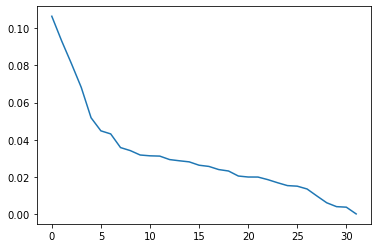

In [368]:
plt.plot(pca.explained_variance_ratio_)

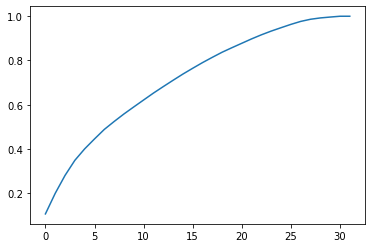

In [369]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))

In [370]:
for variance in [0.95, 0.99, 0.9999999999999999]:
    pca = PCA(variance, whiten=True)
    data = pca.fit_transform(data_for_pca)
    print("For explained variance:", variance, "number of dimensions:", data.shape[1])

For explained variance: 0.95 number of dimensions: 26
For explained variance: 0.99 number of dimensions: 29
For explained variance: 0.9999999999999999 number of dimensions: 32


In [371]:
pca = PCA(n_components = 0.95)
X_train_copy_pca = pca.fit_transform(data_for_pca)
#We have decided not to use PCA since it wouldn't reduce much the dimensionality and we won't gain much by using it

In [372]:
#run classifieres 
knn = KNeighborsClassifier(n_neighbors=3)
lr = LogisticRegression(max_iter=100, penalty='l2')
ann = MLPClassifier(activation = 'relu',hidden_layer_sizes=100)
rf = RandomForestClassifier(criterion = 'entropy')

clfs = [lr,ann,rf]

In [373]:
#implementing Kfold -
k = 5
kf = KFold(n_splits=k, random_state=None) 

LogisticRegression()


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Avg accuracy: 0.6848675524742109
test


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


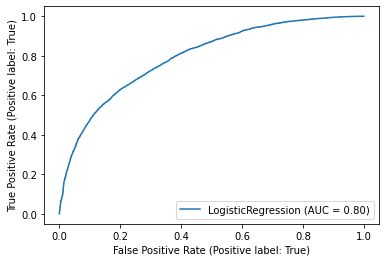

train


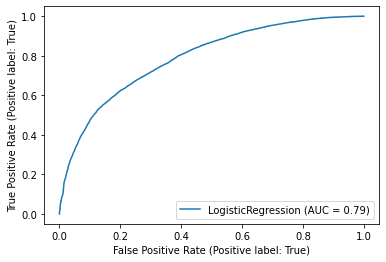

test


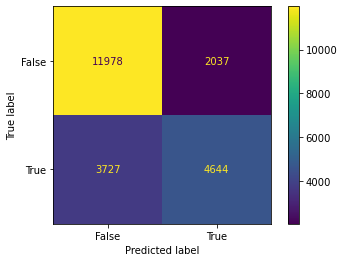

train


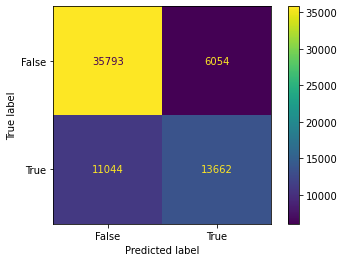

MLPClassifier(hidden_layer_sizes=100)
Avg accuracy: 0.9208893713649552
test


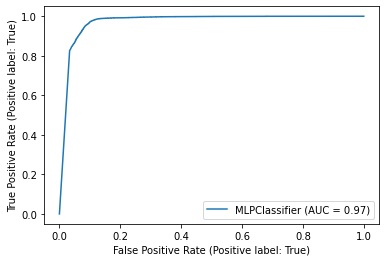

train


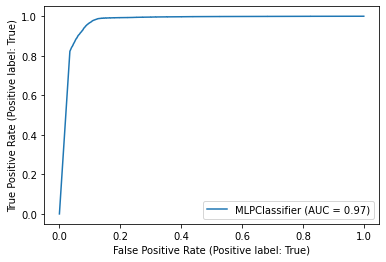

test


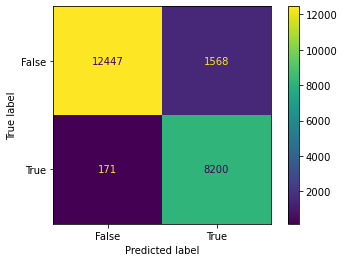

train


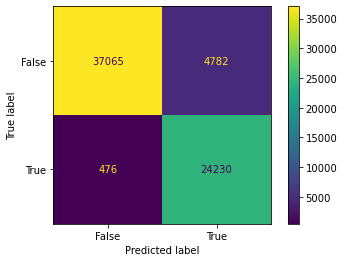

RandomForestClassifier(criterion='entropy')
Avg accuracy: 0.9809475495798061
test


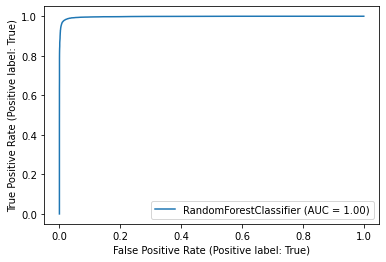

train


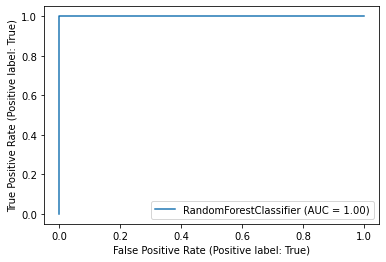

test


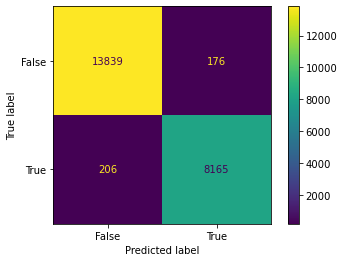

train


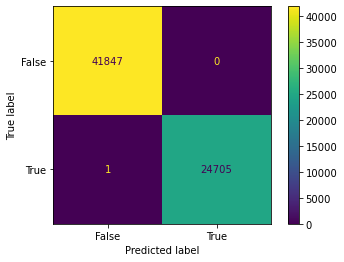

In [374]:
for clf in clfs:
    print(clf)
    clf.fit(X_train_copy, y_train['cancelation'])
    cv_scores = cross_val_score(clf, X_train_copy, y_train['cancelation'], cv=kf)
    print("Avg accuracy: {}".format(cv_scores.mean()))
    print('test')
    plot_roc_curve(clf,X_num_val_copy,y_val['cancelation'])
    plt.show()
    print('train')
    plot_roc_curve(clf,X_train_copy,y_train['cancelation'])
    plt.show()
    print('test')
    plot_confusion_matrix(clf,X_num_val_copy,y_val['cancelation'])
    plt.show()
    print('train')
    plot_confusion_matrix(clf,X_train_copy,y_train['cancelation'])
    plt.show()

In [375]:
misclassifiedIndexes = np.where(y_train['cancelation']!=clf.predict(X_train_copy))[0]
X_train_copy.loc[misclassifiedIndexes,:]

,id,time_until_order,order_year,order_day_of_month,adults,children,prev_canceled,prev_not_canceled,changes,agent,...,anon_feat_11,order_month,order_week,country,order_type,acquisition_channel,deposit_type,customer_type,anon_feat_12,cancelation_percentage
21381,117939,5.0,2017,10,2,0.0,0,0,0.0,9.0,...,2.509045,8.0,32,11,2,1,1.0,2.0,1,0.0


In [ ]:
knn.fit(X_train_copy,y_train['cancelation'])
#train model with cv of 5 
#print each cv score (accuracy) and average them
print(cv_scores)
print('cv_scores mean:{}'.format(np.mean(cv_scores)))

In [ ]:
#Choose best knn

#create a dictionary of all values we want to test for n_neighbors
param_grid = {'n_neighbors':[1,3,5]}
#use gridsearch to test all values for n_neighbors
knn_gscv = GridSearchCV(knn, param_grid, cv=5)
#fit model to data
knn_gscv.fit(X_train_copy, y_train['cancelation'])

In [ ]:
print(knn_gscv.best_params_, '\n', knn_gscv.best_score_)
#we will choose knn with 3 neighbors